In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Employees Table
employees = spark.createDataFrame([
    ('Tono', 34, 'M', 3000, 1),
    ('Ana', 28, 'F', 4100, 2),
    ('Budi', 23, 'M', 2700, 1)
], ['Name','Age','Gender','Salary','DeptID'])

# Departments Table
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptID','DeptName'])

# Projects Table
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptID','ProjectName'])

# Give name to tabel
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptID = d.DeptID
JOIN projects p ON e.DeptID = p.DeptID
''').show()

+----+---+---------+-----------+
|Name|Age| DeptName|ProjectName|
+----+---+---------+-----------+
|Budi| 23|       HR|  Project A|
|Tono| 34|       HR|  Project A|
| Ana| 28|Marketing|  Project B|
+----+---+---------+-----------+



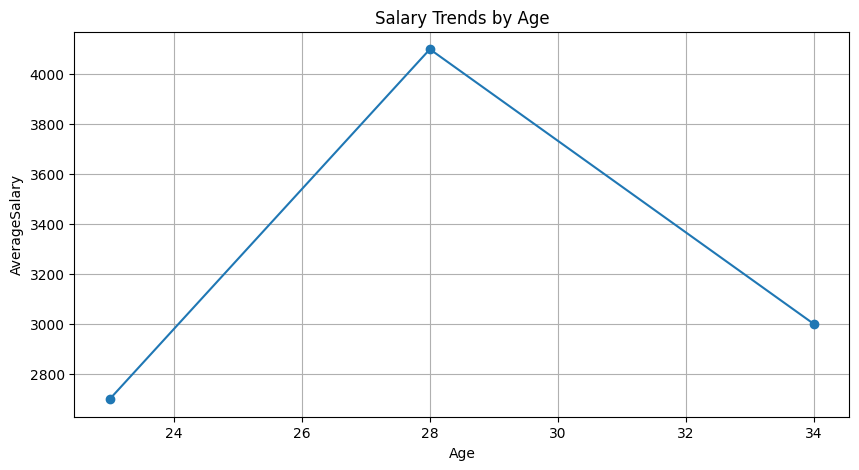

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization
plt.figure(figsize=(10,5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('AverageSalary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

In [5]:
# Rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
spark.sql('''
SELECT e.Name, e.DeptID, e.Salary, AVG(e.Salary) OVER (PARTITION BY e.DeptID) AS RataRataGajiDept,
RANK() OVER (PARTITION BY e.DeptID ORDER BY e.Salary DESC) AS RankGaji
FROM employees e
''').show()

+----+------+------+----------------+--------+
|Name|DeptID|Salary|RataRataGajiDept|RankGaji|
+----+------+------+----------------+--------+
|Tono|     1|  3000|          2850.0|       1|
|Budi|     1|  2700|          2850.0|       2|
| Ana|     2|  4100|          4100.0|       1|
+----+------+------+----------------+--------+



In [6]:
spark.sql('''
SELECT e.Name, e.DeptID, e.Age, e.Salary, AVG(e.Salary) OVER (PARTITION BY e.DeptID, e.Age) AS AvgSalaryPerAgeDept,
ROW_NUMBER() OVER (PARTITION BY e.DeptID ORDER BY e.Age) AS AgeTrendOrder
FROM employees e
ORDER BY e.DeptID, e.Age
''').show()

+----+------+---+------+-------------------+-------------+
|Name|DeptID|Age|Salary|AvgSalaryPerAgeDept|AgeTrendOrder|
+----+------+---+------+-------------------+-------------+
|Budi|     1| 23|  2700|             2700.0|            1|
|Tono|     1| 34|  3000|             3000.0|            2|
| Ana|     2| 28|  4100|             4100.0|            1|
+----+------+---+------+-------------------+-------------+



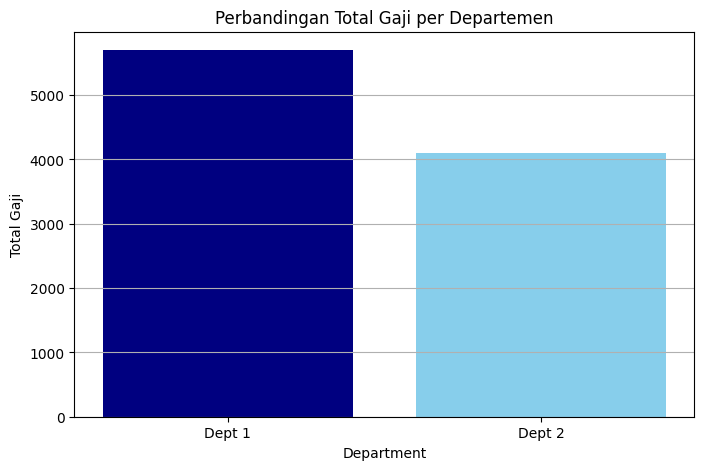

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengubah SQL ke Pandas
salary = spark.sql('''
SELECT DeptID, SUM(Salary) AS TotalSalary, COUNT(*) AS TotalEmployees
FROM employees
GROUP BY DeptID
ORDER BY DeptID
''').toPandas()

# Memberi warna ke grafik batang
colors = ['navy', 'skyblue']

# Visualisasi
plt.figure(figsize=(8,5))
plt.bar(salary['DeptID'], salary['TotalSalary'], color=colors)
plt.xticks([1, 2], ['Dept 1', 'Dept 2'])
plt.xlabel('Department')
plt.ylabel('Total Gaji')
plt.title('Perbandingan Total Gaji per Departemen')
plt.grid(axis='y')
plt.show()

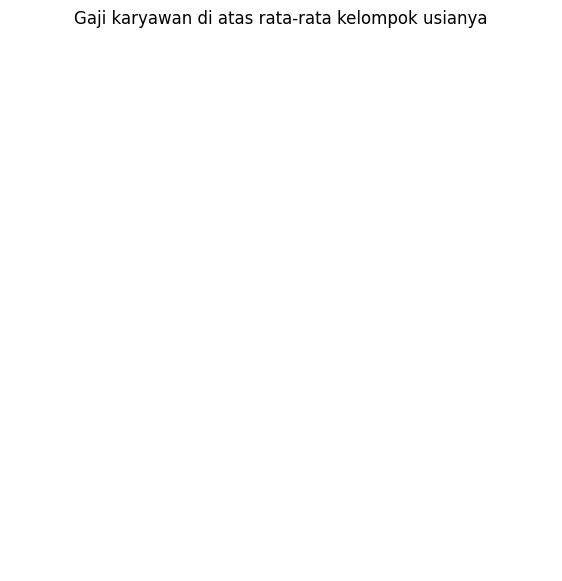

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengubah SQL ke Pandas
rata_rata = spark.sql('''
SELECT e.Name, e.Age, e.Gender, e.Salary
FROM employees e
WHERE e.Salary > (SELECT AVG(e2.Salary)
FROM employees e2
WHERE e2.Age = e.Age)
ORDER BY e.Age
''').toPandas()

# Mengelompokkan SQL berdasarkan usia
kelompok_usia = rata_rata.groupby('Age').size().reset_index(name='Count')

# Visualisasi Pie Chart
plt.figure(figsize=(7,7))
plt.pie(kelompok_usia['Count'], labels=[f'Age {a}' for a in kelompok_usia['Age']], autopct='%1.1f%%', startangle=90)
plt.title('Gaji karyawan di atas rata-rata kelompok usianya')
plt.axis('equal')
plt.show()

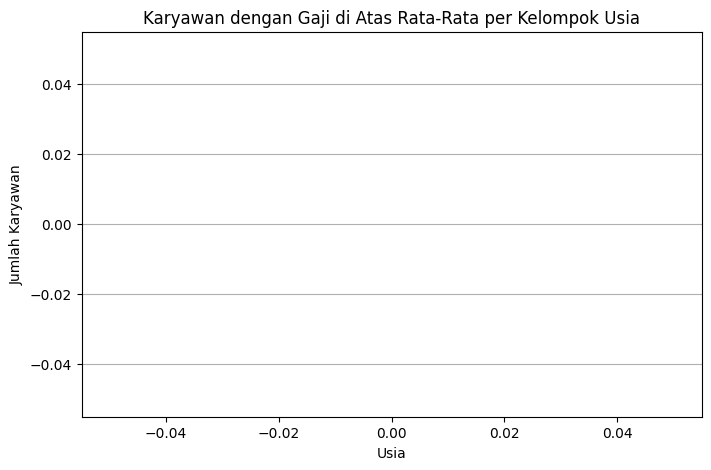

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengubah SQL ke Pandas
rata_rata2 = spark.sql('''
SELECT e.Name, e.Age, e.Gender, e.Salary
FROM employees e
WHERE e.Salary > (SELECT AVG(e2.Salary)
FROM employees e2
WHERE e2.Age = e.Age)
ORDER BY e.Age
''').toPandas()

# # Mengelompokkan SQL berdasarkan usia
kelompok_usia2 = rata_rata2.groupby('Age').size().reset_index(name='Count')

# Visualisasi
plt.figure(figsize=(8,5))
plt.bar(kelompok_usia2['Age'], kelompok_usia2['Count'])
plt.xlabel('Usia')
plt.ylabel('Jumlah Karyawan')
plt.title('Gaji karyawan di atas rata-rata kelompok usianya')
plt.grid(axis='y')
plt.show()